In [1]:
import ROOT
import numpy as np
import pandas as pd

if "/home/submit/pdmonte/CMSSW_10_6_27/src/Hrare2023/analysis/func_marti.so" not in ROOT.gSystem.GetLibraries():
    ROOT.gSystem.CompileMacro("/home/submit/pdmonte/CMSSW_10_6_27/src/Hrare2023/analysis/func_marti.cc","k")

if "/home/submit/pdmonte/CMSSW_10_6_27/src/Hrare2023/analysis/functions.so" not in ROOT.gSystem.GetLibraries():
    ROOT.gSystem.CompileMacro("/home/submit/pdmonte/CMSSW_10_6_27/src/Hrare2023/analysis/functions.cc","k")

Welcome to JupyROOT 6.28/00


In [2]:
def getNumVarsFromCode(code):
    nVars = 0
    while(code > 0):
        nVars += int(code%2)
        code = int(code/2)
    return nVars


def getTotalNumVars(modelName):
    splitted = modelName.split("_")
    numVars = getNumVarsFromCode(int(splitted[1].replace("df", "")))
    numVars += getNumVarsFromCode(int(splitted[2].replace("dl", "")))
    numVars += len(splitted) - 3
    if "opt" in modelName:
        numVars -= 1
    return numVars

In [3]:
modelName="BDTG_df15_dl3684_v0_v1_opt10329"
channel="phi"
date = "SEP25"

s = '''
    TMVA::Experimental::RReader modelScalePhi0("/data/submit/pdmonte/TMVA_models/weightsOpts2/TMVARegression_{modelName}_{channel}_0.weights.xml");
    computeModelScalePhi0 = TMVA::Experimental::Compute<{numVarsTotal}, float>(modelScalePhi0);
    '''.format(modelName=modelName, channel=channel, numVarsTotal=getTotalNumVars(modelName))
s += '''
    TMVA::Experimental::RReader modelScalePhi1("/data/submit/pdmonte/TMVA_models/weightsOpts2/TMVARegression_{modelName}_{channel}_1.weights.xml");
    computeModelScalePhi1 = TMVA::Experimental::Compute<{numVarsTotal}, float>(modelScalePhi1);
    '''.format(modelName=modelName, channel=channel, numVarsTotal=getTotalNumVars(modelName))
s += '''
    TMVA::Experimental::RReader modelScalePhi2("/data/submit/pdmonte/TMVA_models/weightsOpts2/TMVARegression_{modelName}_{channel}_2.weights.xml");
    computeModelScalePhi2 = TMVA::Experimental::Compute<{numVarsTotal}, float>(modelScalePhi2);
    '''.format(modelName=modelName, channel=channel, numVarsTotal=getTotalNumVars(modelName))

ROOT.gInterpreter.ProcessLine(s)
variables = list(ROOT.modelScalePhi0.GetVariableNames())

mesonCat = ""
mesonNum = 0
if (channel == "omega"):
    mesonCat = "OmegaCat"
    mesonNum = 1038
elif (channel == "phi"):
    mesonCat = "Phi3Cat"
    mesonNum = 1039
elif (channel == "d0starrho"):
    mesonCat = "D0StarRhoCat"
    mesonNum = 1040
elif (channel == "d0star"):
    mesonCat = "D0StarCat"
    mesonNum = 1041
else:
    raise Exception("Wrong channel.")

chainSGN0 = ROOT.TChain("events")
chainSGN1 = ROOT.TChain("events")
chainSGN2 = ROOT.TChain("events")
chainSGN0.Add("/data/submit/pdmonte/outputs/{0}/2018/outname_mc{1}_GFcat_{2}_2018_sample0.root".format(date, mesonNum, mesonCat))
chainSGN1.Add("/data/submit/pdmonte/outputs/{0}/2018/outname_mc{1}_GFcat_{2}_2018_sample1.root".format(date, mesonNum, mesonCat))
chainSGN2.Add("/data/submit/pdmonte/outputs/{0}/2018/outname_mc{1}_GFcat_{2}_2018_sample2.root".format(date, mesonNum, mesonCat))

dfSGN0 = ROOT.RDataFrame(chainSGN0)
dfSGN1 = ROOT.RDataFrame(chainSGN1)
dfSGN2 = ROOT.RDataFrame(chainSGN2)

dfSGN0 = (dfSGN0.Define("scale", "w*lumiIntegrated/3.")
        .Define("HCandMass_GEN", "compute_HiggsVars_var(goodMeson_pt_GEN, goodMeson_eta_GEN, goodMeson_phi_GEN, goodMeson_mass_GEN, goodPhotons_pt_GEN, goodPhotons_eta_GEN, goodPhotons_phi_GEN, 0)")
        .Define("HCandMass_varGEN", "compute_HiggsVars_var(goodMeson_pt_GEN, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodPhotons_pt[0], goodPhotons_eta[0], goodPhotons_phi[0], 0)")
        .Define("scaleFactor", ROOT.computeModelScalePhi0, variables)
        .Define("goodMeson_pt_PRED", "scaleFactor[0]*goodMeson_pt[0]")
        .Define("HCandMass_varPRED", "compute_HiggsVars_var(goodMeson_pt_PRED, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodPhotons_pt[0], goodPhotons_eta[0], goodPhotons_phi[0], 0)")
        .Define("Diff_meson_ditrack_pt", "diff2Body(goodMeson_pt_PRED, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodMeson_ditrk_pt[0], goodMeson_ditrk_eta[0], goodMeson_ditrk_phi[0], goodMeson_ditrk_mass[0]).Pt()")
        .Define("Diff_meson_ditrack_pt_noReg", "diff2Body(goodMeson_pt[0], goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodMeson_ditrk_pt[0], goodMeson_ditrk_eta[0], goodMeson_ditrk_phi[0], goodMeson_ditrk_mass[0]).Pt()")
        .Define("Diff_meson_ditrack_pt_GEN", "diff2Body(goodMeson_pt_GEN, goodMeson_eta_GEN, goodMeson_phi_GEN, goodMeson_mass_GEN, goodMeson_ditrk_pt_GEN, goodMeson_ditrk_eta_GEN, goodMeson_ditrk_phi_GEN, goodMeson_ditrk_mass_GEN).Pt()")
        .Define("Diff_meson_ditrack_eta", "diff2Body(goodMeson_pt_PRED, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodMeson_ditrk_pt[0], goodMeson_ditrk_eta[0], goodMeson_ditrk_phi[0], goodMeson_ditrk_mass[0]).Eta()")
        .Define("Diff_meson_ditrack_eta_noReg", "diff2Body(goodMeson_pt[0], goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodMeson_ditrk_pt[0], goodMeson_ditrk_eta[0], goodMeson_ditrk_phi[0], goodMeson_ditrk_mass[0]).Eta()")
        .Define("Diff_meson_ditrack_eta_GEN", "diff2Body(goodMeson_pt_GEN, goodMeson_eta_GEN, goodMeson_phi_GEN, goodMeson_mass_GEN, goodMeson_ditrk_pt_GEN, goodMeson_ditrk_eta_GEN, goodMeson_ditrk_phi_GEN, goodMeson_ditrk_mass_GEN).Eta()")
        .Define("Diff_meson_ditrack_phi", "diff2Body(goodMeson_pt_PRED, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodMeson_ditrk_pt[0], goodMeson_ditrk_eta[0], goodMeson_ditrk_phi[0], goodMeson_ditrk_mass[0]).Phi()")
        .Define("Diff_meson_ditrack_phi_noReg", "diff2Body(goodMeson_pt[0], goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodMeson_ditrk_pt[0], goodMeson_ditrk_eta[0], goodMeson_ditrk_phi[0], goodMeson_ditrk_mass[0]).Phi()")
        .Define("Diff_meson_ditrack_phi_GEN", "diff2Body(goodMeson_pt_GEN, goodMeson_eta_GEN, goodMeson_phi_GEN, goodMeson_mass_GEN, goodMeson_ditrk_pt_GEN, goodMeson_ditrk_eta_GEN, goodMeson_ditrk_phi_GEN, goodMeson_ditrk_mass_GEN).Phi()")
        .Define("Diff_meson_ditrack_mass", "diff2Body(goodMeson_pt_PRED, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodMeson_ditrk_pt[0], goodMeson_ditrk_eta[0], goodMeson_ditrk_phi[0], goodMeson_ditrk_mass[0]).M()")
        .Define("Diff_meson_ditrack_mass_noReg", "diff2Body(goodMeson_pt[0], goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodMeson_ditrk_pt[0], goodMeson_ditrk_eta[0], goodMeson_ditrk_phi[0], goodMeson_ditrk_mass[0]).M()")
        .Define("Diff_meson_ditrack_mass_GEN", "diff2Body(goodMeson_pt_GEN, goodMeson_eta_GEN, goodMeson_phi_GEN, goodMeson_mass_GEN, goodMeson_ditrk_pt_GEN, goodMeson_ditrk_eta_GEN, goodMeson_ditrk_phi_GEN, goodMeson_ditrk_mass_GEN).M()"))
dfSGN1 = (dfSGN1.Define("scale", "w*lumiIntegrated/3.")
        .Define("HCandMass_GEN", "compute_HiggsVars_var(goodMeson_pt_GEN, goodMeson_eta_GEN, goodMeson_phi_GEN, goodMeson_mass_GEN, goodPhotons_pt_GEN, goodPhotons_eta_GEN, goodPhotons_phi_GEN, 0)")
        .Define("HCandMass_varGEN", "compute_HiggsVars_var(goodMeson_pt_GEN, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodPhotons_pt[0], goodPhotons_eta[0], goodPhotons_phi[0], 0)")
        .Define("scaleFactor", ROOT.computeModelScalePhi1, variables)
        .Define("goodMeson_pt_PRED", "scaleFactor[0]*goodMeson_pt[0]")
        .Define("HCandMass_varPRED", "compute_HiggsVars_var(goodMeson_pt_PRED, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodPhotons_pt[0], goodPhotons_eta[0], goodPhotons_phi[0], 0)")
        .Define("Diff_meson_ditrack_pt", "diff2Body(goodMeson_pt_PRED, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodMeson_ditrk_pt[0], goodMeson_ditrk_eta[0], goodMeson_ditrk_phi[0], goodMeson_ditrk_mass[0]).Pt()")
        .Define("Diff_meson_ditrack_pt_noReg", "diff2Body(goodMeson_pt[0], goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodMeson_ditrk_pt[0], goodMeson_ditrk_eta[0], goodMeson_ditrk_phi[0], goodMeson_ditrk_mass[0]).Pt()")
        .Define("Diff_meson_ditrack_pt_GEN", "diff2Body(goodMeson_pt_GEN, goodMeson_eta_GEN, goodMeson_phi_GEN, goodMeson_mass_GEN, goodMeson_ditrk_pt_GEN, goodMeson_ditrk_eta_GEN, goodMeson_ditrk_phi_GEN, goodMeson_ditrk_mass_GEN).Pt()")
        .Define("Diff_meson_ditrack_eta", "diff2Body(goodMeson_pt_PRED, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodMeson_ditrk_pt[0], goodMeson_ditrk_eta[0], goodMeson_ditrk_phi[0], goodMeson_ditrk_mass[0]).Eta()")
        .Define("Diff_meson_ditrack_eta_noReg", "diff2Body(goodMeson_pt[0], goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodMeson_ditrk_pt[0], goodMeson_ditrk_eta[0], goodMeson_ditrk_phi[0], goodMeson_ditrk_mass[0]).Eta()")
        .Define("Diff_meson_ditrack_eta_GEN", "diff2Body(goodMeson_pt_GEN, goodMeson_eta_GEN, goodMeson_phi_GEN, goodMeson_mass_GEN, goodMeson_ditrk_pt_GEN, goodMeson_ditrk_eta_GEN, goodMeson_ditrk_phi_GEN, goodMeson_ditrk_mass_GEN).Eta()")
        .Define("Diff_meson_ditrack_phi", "diff2Body(goodMeson_pt_PRED, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodMeson_ditrk_pt[0], goodMeson_ditrk_eta[0], goodMeson_ditrk_phi[0], goodMeson_ditrk_mass[0]).Phi()")
        .Define("Diff_meson_ditrack_phi_noReg", "diff2Body(goodMeson_pt[0], goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodMeson_ditrk_pt[0], goodMeson_ditrk_eta[0], goodMeson_ditrk_phi[0], goodMeson_ditrk_mass[0]).Phi()")
        .Define("Diff_meson_ditrack_phi_GEN", "diff2Body(goodMeson_pt_GEN, goodMeson_eta_GEN, goodMeson_phi_GEN, goodMeson_mass_GEN, goodMeson_ditrk_pt_GEN, goodMeson_ditrk_eta_GEN, goodMeson_ditrk_phi_GEN, goodMeson_ditrk_mass_GEN).Phi()")
        .Define("Diff_meson_ditrack_mass", "diff2Body(goodMeson_pt_PRED, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodMeson_ditrk_pt[0], goodMeson_ditrk_eta[0], goodMeson_ditrk_phi[0], goodMeson_ditrk_mass[0]).M()")
        .Define("Diff_meson_ditrack_mass_noReg", "diff2Body(goodMeson_pt[0], goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodMeson_ditrk_pt[0], goodMeson_ditrk_eta[0], goodMeson_ditrk_phi[0], goodMeson_ditrk_mass[0]).M()")
        .Define("Diff_meson_ditrack_mass_GEN", "diff2Body(goodMeson_pt_GEN, goodMeson_eta_GEN, goodMeson_phi_GEN, goodMeson_mass_GEN, goodMeson_ditrk_pt_GEN, goodMeson_ditrk_eta_GEN, goodMeson_ditrk_phi_GEN, goodMeson_ditrk_mass_GEN).M()"))
dfSGN2 = (dfSGN2.Define("scale", "w*lumiIntegrated/3.")
        .Define("HCandMass_GEN", "compute_HiggsVars_var(goodMeson_pt_GEN, goodMeson_eta_GEN, goodMeson_phi_GEN, goodMeson_mass_GEN, goodPhotons_pt_GEN, goodPhotons_eta_GEN, goodPhotons_phi_GEN, 0)")
        .Define("HCandMass_varGEN", "compute_HiggsVars_var(goodMeson_pt_GEN, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodPhotons_pt[0], goodPhotons_eta[0], goodPhotons_phi[0], 0)")
        .Define("scaleFactor", ROOT.computeModelScalePhi2, variables)
        .Define("goodMeson_pt_PRED", "scaleFactor[0]*goodMeson_pt[0]")
        .Define("HCandMass_varPRED", "compute_HiggsVars_var(goodMeson_pt_PRED, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodPhotons_pt[0], goodPhotons_eta[0], goodPhotons_phi[0], 0)")
        .Define("Diff_meson_ditrack_pt", "diff2Body(goodMeson_pt_PRED, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodMeson_ditrk_pt[0], goodMeson_ditrk_eta[0], goodMeson_ditrk_phi[0], goodMeson_ditrk_mass[0]).Pt()")
        .Define("Diff_meson_ditrack_pt_noReg", "diff2Body(goodMeson_pt[0], goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodMeson_ditrk_pt[0], goodMeson_ditrk_eta[0], goodMeson_ditrk_phi[0], goodMeson_ditrk_mass[0]).Pt()")
        .Define("Diff_meson_ditrack_pt_GEN", "diff2Body(goodMeson_pt_GEN, goodMeson_eta_GEN, goodMeson_phi_GEN, goodMeson_mass_GEN, goodMeson_ditrk_pt_GEN, goodMeson_ditrk_eta_GEN, goodMeson_ditrk_phi_GEN, goodMeson_ditrk_mass_GEN).Pt()")
        .Define("Diff_meson_ditrack_eta", "diff2Body(goodMeson_pt_PRED, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodMeson_ditrk_pt[0], goodMeson_ditrk_eta[0], goodMeson_ditrk_phi[0], goodMeson_ditrk_mass[0]).Eta()")
        .Define("Diff_meson_ditrack_eta_noReg", "diff2Body(goodMeson_pt[0], goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodMeson_ditrk_pt[0], goodMeson_ditrk_eta[0], goodMeson_ditrk_phi[0], goodMeson_ditrk_mass[0]).Eta()")
        .Define("Diff_meson_ditrack_eta_GEN", "diff2Body(goodMeson_pt_GEN, goodMeson_eta_GEN, goodMeson_phi_GEN, goodMeson_mass_GEN, goodMeson_ditrk_pt_GEN, goodMeson_ditrk_eta_GEN, goodMeson_ditrk_phi_GEN, goodMeson_ditrk_mass_GEN).Eta()")
        .Define("Diff_meson_ditrack_phi", "diff2Body(goodMeson_pt_PRED, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodMeson_ditrk_pt[0], goodMeson_ditrk_eta[0], goodMeson_ditrk_phi[0], goodMeson_ditrk_mass[0]).Phi()")
        .Define("Diff_meson_ditrack_phi_noReg", "diff2Body(goodMeson_pt[0], goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodMeson_ditrk_pt[0], goodMeson_ditrk_eta[0], goodMeson_ditrk_phi[0], goodMeson_ditrk_mass[0]).Phi()")
        .Define("Diff_meson_ditrack_phi_GEN", "diff2Body(goodMeson_pt_GEN, goodMeson_eta_GEN, goodMeson_phi_GEN, goodMeson_mass_GEN, goodMeson_ditrk_pt_GEN, goodMeson_ditrk_eta_GEN, goodMeson_ditrk_phi_GEN, goodMeson_ditrk_mass_GEN).Phi()")
        .Define("Diff_meson_ditrack_mass", "diff2Body(goodMeson_pt_PRED, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodMeson_ditrk_pt[0], goodMeson_ditrk_eta[0], goodMeson_ditrk_phi[0], goodMeson_ditrk_mass[0]).M()")
        .Define("Diff_meson_ditrack_mass_noReg", "diff2Body(goodMeson_pt[0], goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodMeson_ditrk_pt[0], goodMeson_ditrk_eta[0], goodMeson_ditrk_phi[0], goodMeson_ditrk_mass[0]).M()")
        .Define("Diff_meson_ditrack_mass_GEN", "diff2Body(goodMeson_pt_GEN, goodMeson_eta_GEN, goodMeson_phi_GEN, goodMeson_mass_GEN, goodMeson_ditrk_pt_GEN, goodMeson_ditrk_eta_GEN, goodMeson_ditrk_phi_GEN, goodMeson_ditrk_mass_GEN).M()"))

STD REGRESSION:	 4.094572468623752
STD NO REGRESSION:	 6.0196307361735215


Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


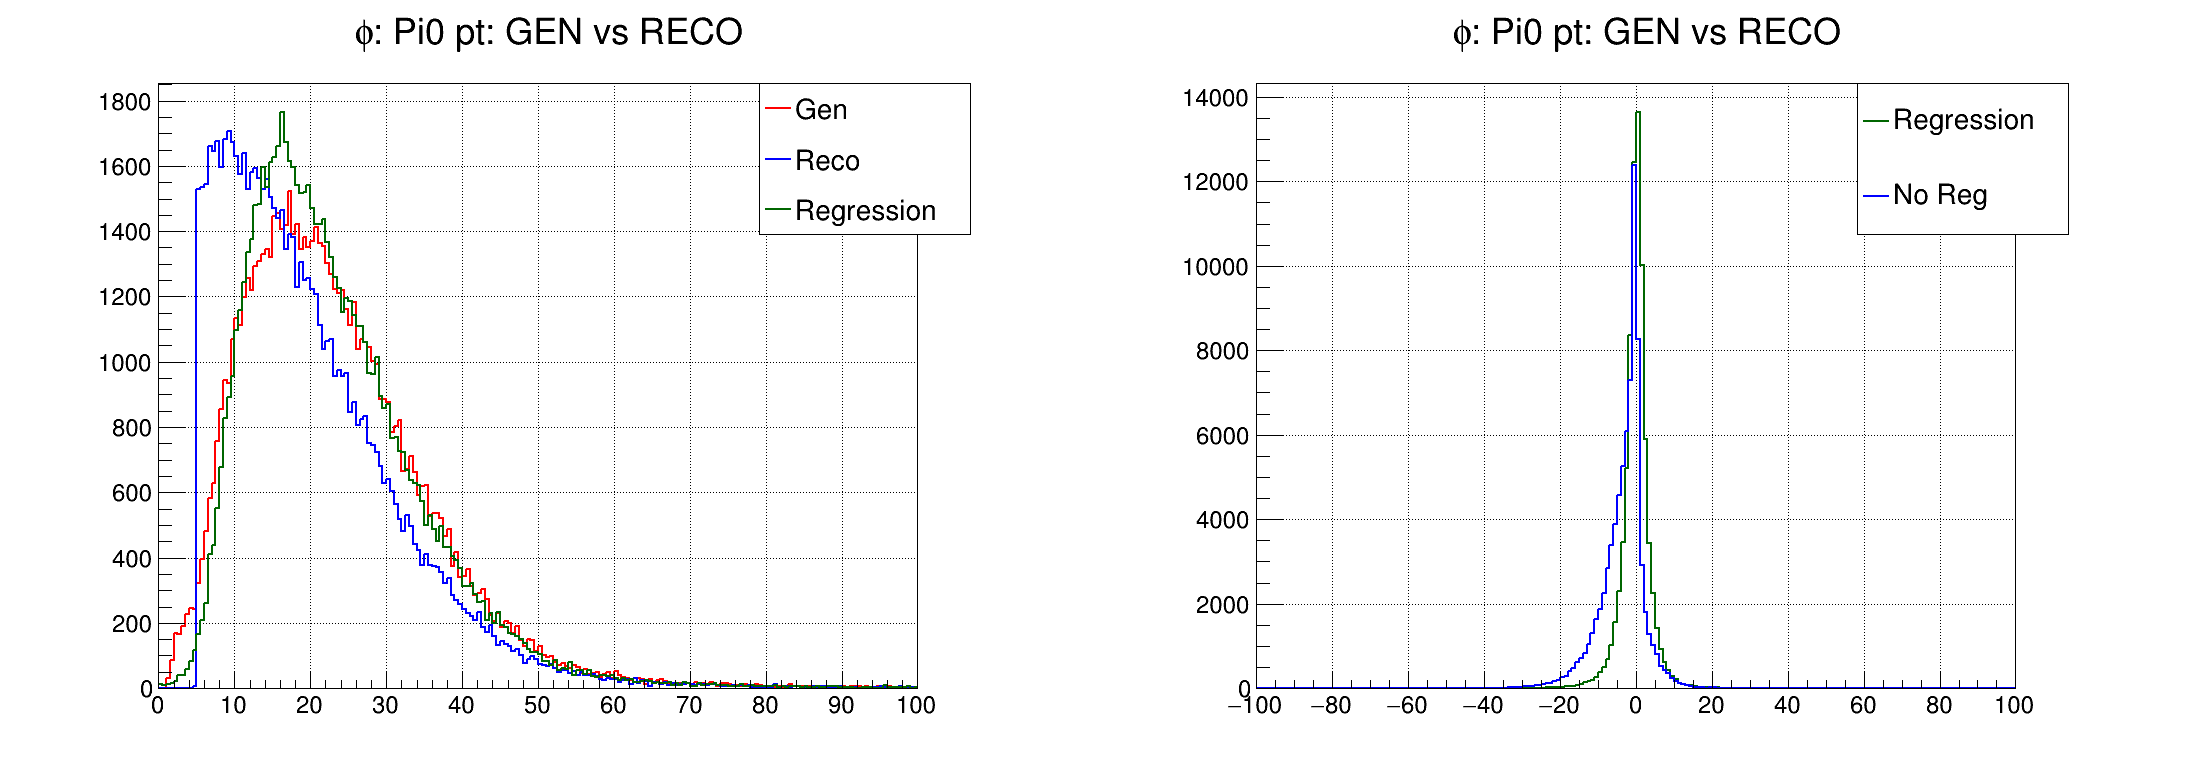

In [6]:
canvas = ROOT.TCanvas("canvas", "canvas", 2200, 800)
canvas.Divide(2, 1)

nbins, xlow, xhigh = 200, 0.0, 100

p = canvas.cd(1)

h1GEN1 = dfSGN0.Histo1D(("1Dhist", "#{channel}: pi0 pt Gen".format(channel=channel), nbins, xlow, xhigh), "Diff_meson_ditrack_pt_GEN").GetValue()
h1GEN1.Add(dfSGN1.Histo1D(("1Dhist", "#{channel}: pi0 pt Gen".format(channel=channel), nbins, xlow, xhigh), "Diff_meson_ditrack_pt_GEN").GetValue())
h1GEN1.Add(dfSGN2.Histo1D(("1Dhist", "#{channel}: pi0 pt Gen".format(channel=channel), nbins, xlow, xhigh), "Diff_meson_ditrack_pt_GEN").GetValue())

h1GEN1.GetXaxis().SetTitle("pi0 pt")
h1GEN1.GetYaxis().SetTitle("Events")
h1GEN1.SetLineWidth(2)
h1GEN1.SetLineColor(ROOT.kRed)

h1Regr = dfSGN0.Histo1D(("1Dhist", "#{channel}: pi0 pt Reco".format(channel=channel), nbins, xlow, xhigh), "Diff_meson_ditrack_pt").GetValue()
h1Regr.Add(dfSGN1.Histo1D(("1Dhist", "#{channel}: pi0 pt Reco".format(channel=channel), nbins, xlow, xhigh), "Diff_meson_ditrack_pt").GetValue())
h1Regr.Add(dfSGN2.Histo1D(("1Dhist", "#{channel}: pi0 pt Reco".format(channel=channel), nbins, xlow, xhigh), "Diff_meson_ditrack_pt").GetValue())

h1Regr.GetXaxis().SetTitle("pi0 pt")
h1Regr.GetYaxis().SetTitle("Events")
h1Regr.SetLineWidth(2)
h1Regr.SetLineColor(ROOT.kGreen+3)

h1Reco = dfSGN0.Histo1D(("1Dhist", "#{channel}: pi0 pt Reco".format(channel=channel), nbins, xlow, xhigh), "Diff_meson_ditrack_pt_noReg").GetValue()
h1Reco.Add(dfSGN1.Histo1D(("1Dhist", "#{channel}: pi0 pt Reco".format(channel=channel), nbins, xlow, xhigh), "Diff_meson_ditrack_pt_noReg").GetValue())
h1Reco.Add(dfSGN2.Histo1D(("1Dhist", "#{channel}: pi0 pt Reco".format(channel=channel), nbins, xlow, xhigh), "Diff_meson_ditrack_pt_noReg").GetValue())

h1Reco.GetXaxis().SetTitle("pi0 pt")
h1Reco.GetYaxis().SetTitle("Events")
h1Reco.SetLineWidth(2)
h1Reco.SetLineColor(ROOT.kBlue)

p.SetRightMargin(0.15)
p.SetLeftMargin(0.13)
p.SetGrid()

stack4 = ROOT.THStack("stack", "#{channel}: Pi0 pt: GEN vs RECO".format(channel=channel))
stack4.Add(h1GEN1)
stack4.Add(h1Reco)
stack4.Add(h1Regr)
stack4.Draw("hist nostack")
legend4 = ROOT.TLegend(0.70, 0.70, 0.9, 0.9)
legend4.SetMargin(0.17)
legend4.SetTextSize(0.04)
legend4.AddEntry(h1GEN1, "Gen", "l")
legend4.AddEntry(h1Reco, "Reco", "l")
legend4.AddEntry(h1Regr, "Regression", "l")
legend4.Draw()


p = canvas.cd(2)





xlen = 100.
nbins, xlow, xhigh = 200, -xlen, xlen
h1DiffReg = dfSGN0.Define("diff", "Diff_meson_ditrack_pt - Diff_meson_ditrack_pt_GEN").Histo1D(("1Dhist", "#{channel}: Diff pt".format(channel=channel), nbins, xlow, xhigh), "diff").GetValue()
h1DiffReg.Add(dfSGN1.Define("diff", "Diff_meson_ditrack_pt - Diff_meson_ditrack_pt_GEN").Histo1D(("1Dhist", "#{channel}: Diff pt".format(channel=channel), nbins, xlow, xhigh), "diff").GetValue())
h1DiffReg.Add(dfSGN2.Define("diff", "Diff_meson_ditrack_pt - Diff_meson_ditrack_pt_GEN").Histo1D(("1Dhist", "#{channel}: Diff pt".format(channel=channel), nbins, xlow, xhigh), "diff").GetValue())

h1DiffReg.GetXaxis().SetTitle("Diff")
h1DiffReg.GetYaxis().SetTitle("Events")
h1DiffReg.SetLineWidth(2)
h1DiffReg.SetLineColor(ROOT.kGreen+3)

h1DiffNoReg = dfSGN0.Define("diff", "Diff_meson_ditrack_pt_noReg - Diff_meson_ditrack_pt_GEN").Histo1D(("1Dhist", "#{channel}: Diff pt".format(channel=channel), nbins, xlow, xhigh), "diff").GetValue()
h1DiffNoReg.Add(dfSGN1.Define("diff", "Diff_meson_ditrack_pt_noReg - Diff_meson_ditrack_pt_GEN").Histo1D(("1Dhist", "#{channel}: Diff pt".format(channel=channel), nbins, xlow, xhigh), "diff").GetValue())
h1DiffNoReg.Add(dfSGN2.Define("diff", "Diff_meson_ditrack_pt_noReg - Diff_meson_ditrack_pt_GEN").Histo1D(("1Dhist", "#{channel}: Diff pt".format(channel=channel), nbins, xlow, xhigh), "diff").GetValue())

h1DiffNoReg.GetXaxis().SetTitle("Diff")
h1DiffNoReg.GetYaxis().SetTitle("Events")
h1DiffNoReg.SetLineWidth(2)
h1DiffNoReg.SetLineColor(ROOT.kBlue)

p.SetRightMargin(0.15)
p.SetLeftMargin(0.13)
p.SetGrid()

stack5 = ROOT.THStack("stack", "#{channel}: Pi0 pt: GEN vs RECO".format(channel=channel))
stack5.Add(h1DiffReg)
stack5.Add(h1DiffNoReg)
stack5.Draw("hist nostack")
legend5 = ROOT.TLegend(0.70, 0.70, 0.9, 0.9)
legend5.SetMargin(0.17)
legend5.SetTextSize(0.04)
legend5.AddEntry(h1DiffReg, "Regression", "l")
legend5.AddEntry(h1DiffNoReg, "No Reg", "l")
legend5.Draw()

canvas.Draw()

print("STD REGRESSION:\t", h1DiffReg.GetStdDev())
print("STD NO REGRESSION:\t", h1DiffNoReg.GetStdDev())

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


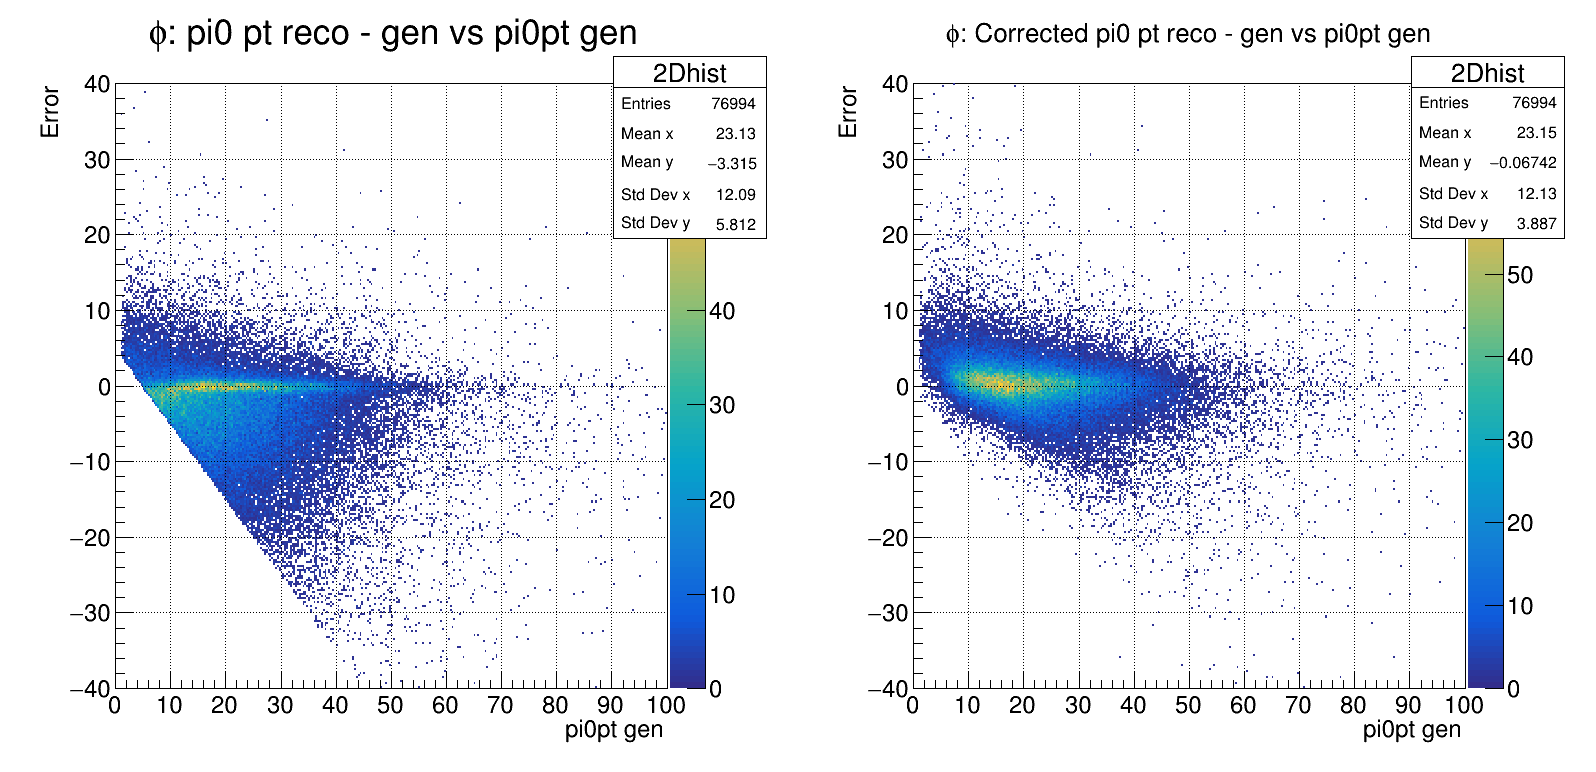

In [12]:
canvas = ROOT.TCanvas("canvas", "canvas", 1600, 800)
canvas.Divide(2, 1)

nbins, xlow, xhigh, ylow, yhigh = 300, 0, 100, -40, 40

p = canvas.cd(1)

h1 = dfSGN0.Define("diff", "Diff_meson_ditrack_pt_noReg - Diff_meson_ditrack_pt_GEN").Histo2D(("2Dhist", "#{channel}: pi0 pt reco - gen vs pi0pt gen".format(channel=channel), nbins, xlow, xhigh, nbins, ylow, yhigh), "Diff_meson_ditrack_pt_GEN", "diff").GetValue()
h1.Add(dfSGN1.Define("diff", "Diff_meson_ditrack_pt_noReg - Diff_meson_ditrack_pt_GEN").Histo2D(("2Dhist", "#{channel}: pi0 pt reco - gen vs pi0pt gen".format(channel=channel), nbins, xlow, xhigh, nbins, ylow, yhigh), "Diff_meson_ditrack_pt_GEN", "diff").GetValue())
h1.Add(dfSGN2.Define("diff", "Diff_meson_ditrack_pt_noReg - Diff_meson_ditrack_pt_GEN").Histo2D(("2Dhist", "#{channel}: pi0 pt reco - gen vs pi0pt gen".format(channel=channel), nbins, xlow, xhigh, nbins, ylow, yhigh), "Diff_meson_ditrack_pt_GEN", "diff").GetValue())

h1.GetXaxis().SetTitle("pi0pt gen")
h1.GetYaxis().SetTitle("Error")
h1.GetZaxis().SetTitle("Events")
p.SetRightMargin(0.15)
p.SetLeftMargin(0.13)

h1.SetContour(100)
h1.Draw("colz")
p.SetGrid()


p = canvas.cd(2)

h1Pred = dfSGN0.Define("diff", "Diff_meson_ditrack_pt - Diff_meson_ditrack_pt_GEN").Histo2D(("2Dhist", "#{channel}: Corrected pi0 pt reco - gen vs pi0pt gen".format(channel=channel), nbins, xlow, xhigh, nbins, ylow, yhigh), "Diff_meson_ditrack_pt_GEN", "diff").GetValue()
h1Pred.Add(dfSGN1.Define("diff", "Diff_meson_ditrack_pt - Diff_meson_ditrack_pt_GEN").Histo2D(("2Dhist", "#{channel}: Corrected pi0 pt reco - gen vs pi0pt gen".format(channel=channel), nbins, xlow, xhigh, nbins, ylow, yhigh), "Diff_meson_ditrack_pt_GEN", "diff").GetValue())
h1Pred.Add(dfSGN2.Define("diff", "Diff_meson_ditrack_pt - Diff_meson_ditrack_pt_GEN").Histo2D(("2Dhist", "#{channel}: Corrected pi0 pt reco - gen vs pi0pt gen".format(channel=channel), nbins, xlow, xhigh, nbins, ylow, yhigh), "Diff_meson_ditrack_pt_GEN", "diff").GetValue())

h1Pred.GetXaxis().SetTitle("pi0pt gen")
h1Pred.GetYaxis().SetTitle("Error")
h1Pred.GetZaxis().SetTitle("Events")
p.SetRightMargin(0.15)
p.SetLeftMargin(0.13)

h1Pred.SetContour(100)
h1Pred.Draw("colz")
p.SetGrid()

canvas.Draw()

In [5]:
modelName="BDTG_df15_dl3684_v0_v1_opt11264"
channel="omega"
date = "SEP25"

s = '''
    TMVA::Experimental::RReader modelScaleOmega0("/data/submit/pdmonte/TMVA_models/weightsOpts2/TMVARegression_{modelName}_{channel}_0.weights.xml");
    computeModelScaleOmega0 = TMVA::Experimental::Compute<{numVarsTotal}, float>(modelScaleOmega0);
    '''.format(modelName=modelName, channel=channel, numVarsTotal=getTotalNumVars(modelName))
s += '''
    TMVA::Experimental::RReader modelScaleOmega1("/data/submit/pdmonte/TMVA_models/weightsOpts2/TMVARegression_{modelName}_{channel}_1.weights.xml");
    computeModelScaleOmega1 = TMVA::Experimental::Compute<{numVarsTotal}, float>(modelScaleOmega1);
    '''.format(modelName=modelName, channel=channel, numVarsTotal=getTotalNumVars(modelName))
s += '''
    TMVA::Experimental::RReader modelScaleOmega2("/data/submit/pdmonte/TMVA_models/weightsOpts2/TMVARegression_{modelName}_{channel}_2.weights.xml");
    computeModelScaleOmega2 = TMVA::Experimental::Compute<{numVarsTotal}, float>(modelScaleOmega2);
    '''.format(modelName=modelName, channel=channel, numVarsTotal=getTotalNumVars(modelName))

ROOT.gInterpreter.ProcessLine(s)
variables = list(ROOT.modelScaleOmega0.GetVariableNames())

mesonCat = ""
mesonNum = 0
if (channel == "omega"):
    mesonCat = "OmegaCat"
    mesonNum = 1038
elif (channel == "phi"):
    mesonCat = "Phi3Cat"
    mesonNum = 1039
elif (channel == "d0starrho"):
    mesonCat = "D0StarRhoCat"
    mesonNum = 1040
elif (channel == "d0star"):
    mesonCat = "D0StarCat"
    mesonNum = 1041
else:
    raise Exception("Wrong channel.")

chainSGN0 = ROOT.TChain("events")
chainSGN1 = ROOT.TChain("events")
chainSGN2 = ROOT.TChain("events")
chainSGN0.Add("/data/submit/pdmonte/outputs/{0}/2018/outname_mc{1}_GFcat_{2}_2018_sample0.root".format(date, mesonNum, mesonCat))
chainSGN1.Add("/data/submit/pdmonte/outputs/{0}/2018/outname_mc{1}_GFcat_{2}_2018_sample1.root".format(date, mesonNum, mesonCat))
chainSGN2.Add("/data/submit/pdmonte/outputs/{0}/2018/outname_mc{1}_GFcat_{2}_2018_sample2.root".format(date, mesonNum, mesonCat))

dfSGN0 = ROOT.RDataFrame(chainSGN0)
dfSGN1 = ROOT.RDataFrame(chainSGN1)
dfSGN2 = ROOT.RDataFrame(chainSGN2)

dfSGN0 = (dfSGN0.Define("scale", "w*lumiIntegrated/3.")
        .Define("HCandMass_GEN", "compute_HiggsVars_var(goodMeson_pt_GEN, goodMeson_eta_GEN, goodMeson_phi_GEN, goodMeson_mass_GEN, goodPhotons_pt_GEN, goodPhotons_eta_GEN, goodPhotons_phi_GEN, 0)")
        .Define("HCandMass_varGEN", "compute_HiggsVars_var(goodMeson_pt_GEN, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodPhotons_pt[0], goodPhotons_eta[0], goodPhotons_phi[0], 0)")
        .Define("scaleFactor", ROOT.computeModelScaleOmega0, variables)
        .Define("goodMeson_pt_PRED", "scaleFactor[0]*goodMeson_pt[0]")
        .Define("HCandMass_varPRED", "compute_HiggsVars_var(goodMeson_pt_PRED, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodPhotons_pt[0], goodPhotons_eta[0], goodPhotons_phi[0], 0)")
        .Define("Diff_meson_ditrack_pt", "diff2Body(goodMeson_pt_PRED, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodMeson_ditrk_pt[0], goodMeson_ditrk_eta[0], goodMeson_ditrk_phi[0], goodMeson_ditrk_mass[0]).Pt()")
        .Define("Diff_meson_ditrack_pt_noReg", "diff2Body(goodMeson_pt[0], goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodMeson_ditrk_pt[0], goodMeson_ditrk_eta[0], goodMeson_ditrk_phi[0], goodMeson_ditrk_mass[0]).Pt()")
        .Define("Diff_meson_ditrack_pt_GEN", "diff2Body(goodMeson_pt_GEN, goodMeson_eta_GEN, goodMeson_phi_GEN, goodMeson_mass_GEN, goodMeson_ditrk_pt_GEN, goodMeson_ditrk_eta_GEN, goodMeson_ditrk_phi_GEN, goodMeson_ditrk_mass_GEN).Pt()")
        .Define("Diff_meson_ditrack_eta", "diff2Body(goodMeson_pt_PRED, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodMeson_ditrk_pt[0], goodMeson_ditrk_eta[0], goodMeson_ditrk_phi[0], goodMeson_ditrk_mass[0]).Eta()")
        .Define("Diff_meson_ditrack_eta_noReg", "diff2Body(goodMeson_pt[0], goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodMeson_ditrk_pt[0], goodMeson_ditrk_eta[0], goodMeson_ditrk_phi[0], goodMeson_ditrk_mass[0]).Eta()")
        .Define("Diff_meson_ditrack_eta_GEN", "diff2Body(goodMeson_pt_GEN, goodMeson_eta_GEN, goodMeson_phi_GEN, goodMeson_mass_GEN, goodMeson_ditrk_pt_GEN, goodMeson_ditrk_eta_GEN, goodMeson_ditrk_phi_GEN, goodMeson_ditrk_mass_GEN).Eta()")
        .Define("Diff_meson_ditrack_phi", "diff2Body(goodMeson_pt_PRED, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodMeson_ditrk_pt[0], goodMeson_ditrk_eta[0], goodMeson_ditrk_phi[0], goodMeson_ditrk_mass[0]).Phi()")
        .Define("Diff_meson_ditrack_phi_noReg", "diff2Body(goodMeson_pt[0], goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodMeson_ditrk_pt[0], goodMeson_ditrk_eta[0], goodMeson_ditrk_phi[0], goodMeson_ditrk_mass[0]).Phi()")
        .Define("Diff_meson_ditrack_phi_GEN", "diff2Body(goodMeson_pt_GEN, goodMeson_eta_GEN, goodMeson_phi_GEN, goodMeson_mass_GEN, goodMeson_ditrk_pt_GEN, goodMeson_ditrk_eta_GEN, goodMeson_ditrk_phi_GEN, goodMeson_ditrk_mass_GEN).Phi()")
        .Define("Diff_meson_ditrack_mass", "diff2Body(goodMeson_pt_PRED, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodMeson_ditrk_pt[0], goodMeson_ditrk_eta[0], goodMeson_ditrk_phi[0], goodMeson_ditrk_mass[0]).M()")
        .Define("Diff_meson_ditrack_mass_noReg", "diff2Body(goodMeson_pt[0], goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodMeson_ditrk_pt[0], goodMeson_ditrk_eta[0], goodMeson_ditrk_phi[0], goodMeson_ditrk_mass[0]).M()")
        .Define("Diff_meson_ditrack_mass_GEN", "diff2Body(goodMeson_pt_GEN, goodMeson_eta_GEN, goodMeson_phi_GEN, goodMeson_mass_GEN, goodMeson_ditrk_pt_GEN, goodMeson_ditrk_eta_GEN, goodMeson_ditrk_phi_GEN, goodMeson_ditrk_mass_GEN).M()"))
dfSGN1 = (dfSGN1.Define("scale", "w*lumiIntegrated/3.")
        .Define("HCandMass_GEN", "compute_HiggsVars_var(goodMeson_pt_GEN, goodMeson_eta_GEN, goodMeson_phi_GEN, goodMeson_mass_GEN, goodPhotons_pt_GEN, goodPhotons_eta_GEN, goodPhotons_phi_GEN, 0)")
        .Define("HCandMass_varGEN", "compute_HiggsVars_var(goodMeson_pt_GEN, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodPhotons_pt[0], goodPhotons_eta[0], goodPhotons_phi[0], 0)")
        .Define("scaleFactor", ROOT.computeModelScaleOmega1, variables)
        .Define("goodMeson_pt_PRED", "scaleFactor[0]*goodMeson_pt[0]")
        .Define("HCandMass_varPRED", "compute_HiggsVars_var(goodMeson_pt_PRED, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodPhotons_pt[0], goodPhotons_eta[0], goodPhotons_phi[0], 0)")
        .Define("Diff_meson_ditrack_pt", "diff2Body(goodMeson_pt_PRED, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodMeson_ditrk_pt[0], goodMeson_ditrk_eta[0], goodMeson_ditrk_phi[0], goodMeson_ditrk_mass[0]).Pt()")
        .Define("Diff_meson_ditrack_pt_noReg", "diff2Body(goodMeson_pt[0], goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodMeson_ditrk_pt[0], goodMeson_ditrk_eta[0], goodMeson_ditrk_phi[0], goodMeson_ditrk_mass[0]).Pt()")
        .Define("Diff_meson_ditrack_pt_GEN", "diff2Body(goodMeson_pt_GEN, goodMeson_eta_GEN, goodMeson_phi_GEN, goodMeson_mass_GEN, goodMeson_ditrk_pt_GEN, goodMeson_ditrk_eta_GEN, goodMeson_ditrk_phi_GEN, goodMeson_ditrk_mass_GEN).Pt()")
        .Define("Diff_meson_ditrack_eta", "diff2Body(goodMeson_pt_PRED, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodMeson_ditrk_pt[0], goodMeson_ditrk_eta[0], goodMeson_ditrk_phi[0], goodMeson_ditrk_mass[0]).Eta()")
        .Define("Diff_meson_ditrack_eta_noReg", "diff2Body(goodMeson_pt[0], goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodMeson_ditrk_pt[0], goodMeson_ditrk_eta[0], goodMeson_ditrk_phi[0], goodMeson_ditrk_mass[0]).Eta()")
        .Define("Diff_meson_ditrack_eta_GEN", "diff2Body(goodMeson_pt_GEN, goodMeson_eta_GEN, goodMeson_phi_GEN, goodMeson_mass_GEN, goodMeson_ditrk_pt_GEN, goodMeson_ditrk_eta_GEN, goodMeson_ditrk_phi_GEN, goodMeson_ditrk_mass_GEN).Eta()")
        .Define("Diff_meson_ditrack_phi", "diff2Body(goodMeson_pt_PRED, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodMeson_ditrk_pt[0], goodMeson_ditrk_eta[0], goodMeson_ditrk_phi[0], goodMeson_ditrk_mass[0]).Phi()")
        .Define("Diff_meson_ditrack_phi_noReg", "diff2Body(goodMeson_pt[0], goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodMeson_ditrk_pt[0], goodMeson_ditrk_eta[0], goodMeson_ditrk_phi[0], goodMeson_ditrk_mass[0]).Phi()")
        .Define("Diff_meson_ditrack_phi_GEN", "diff2Body(goodMeson_pt_GEN, goodMeson_eta_GEN, goodMeson_phi_GEN, goodMeson_mass_GEN, goodMeson_ditrk_pt_GEN, goodMeson_ditrk_eta_GEN, goodMeson_ditrk_phi_GEN, goodMeson_ditrk_mass_GEN).Phi()")
        .Define("Diff_meson_ditrack_mass", "diff2Body(goodMeson_pt_PRED, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodMeson_ditrk_pt[0], goodMeson_ditrk_eta[0], goodMeson_ditrk_phi[0], goodMeson_ditrk_mass[0]).M()")
        .Define("Diff_meson_ditrack_mass_noReg", "diff2Body(goodMeson_pt[0], goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodMeson_ditrk_pt[0], goodMeson_ditrk_eta[0], goodMeson_ditrk_phi[0], goodMeson_ditrk_mass[0]).M()")
        .Define("Diff_meson_ditrack_mass_GEN", "diff2Body(goodMeson_pt_GEN, goodMeson_eta_GEN, goodMeson_phi_GEN, goodMeson_mass_GEN, goodMeson_ditrk_pt_GEN, goodMeson_ditrk_eta_GEN, goodMeson_ditrk_phi_GEN, goodMeson_ditrk_mass_GEN).M()"))
dfSGN2 = (dfSGN2.Define("scale", "w*lumiIntegrated/3.")
        .Define("HCandMass_GEN", "compute_HiggsVars_var(goodMeson_pt_GEN, goodMeson_eta_GEN, goodMeson_phi_GEN, goodMeson_mass_GEN, goodPhotons_pt_GEN, goodPhotons_eta_GEN, goodPhotons_phi_GEN, 0)")
        .Define("HCandMass_varGEN", "compute_HiggsVars_var(goodMeson_pt_GEN, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodPhotons_pt[0], goodPhotons_eta[0], goodPhotons_phi[0], 0)")
        .Define("scaleFactor", ROOT.computeModelScaleOmega2, variables)
        .Define("goodMeson_pt_PRED", "scaleFactor[0]*goodMeson_pt[0]")
        .Define("HCandMass_varPRED", "compute_HiggsVars_var(goodMeson_pt_PRED, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodPhotons_pt[0], goodPhotons_eta[0], goodPhotons_phi[0], 0)")
        .Define("Diff_meson_ditrack_pt", "diff2Body(goodMeson_pt_PRED, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodMeson_ditrk_pt[0], goodMeson_ditrk_eta[0], goodMeson_ditrk_phi[0], goodMeson_ditrk_mass[0]).Pt()")
        .Define("Diff_meson_ditrack_pt_noReg", "diff2Body(goodMeson_pt[0], goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodMeson_ditrk_pt[0], goodMeson_ditrk_eta[0], goodMeson_ditrk_phi[0], goodMeson_ditrk_mass[0]).Pt()")
        .Define("Diff_meson_ditrack_pt_GEN", "diff2Body(goodMeson_pt_GEN, goodMeson_eta_GEN, goodMeson_phi_GEN, goodMeson_mass_GEN, goodMeson_ditrk_pt_GEN, goodMeson_ditrk_eta_GEN, goodMeson_ditrk_phi_GEN, goodMeson_ditrk_mass_GEN).Pt()")
        .Define("Diff_meson_ditrack_eta", "diff2Body(goodMeson_pt_PRED, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodMeson_ditrk_pt[0], goodMeson_ditrk_eta[0], goodMeson_ditrk_phi[0], goodMeson_ditrk_mass[0]).Eta()")
        .Define("Diff_meson_ditrack_eta_noReg", "diff2Body(goodMeson_pt[0], goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodMeson_ditrk_pt[0], goodMeson_ditrk_eta[0], goodMeson_ditrk_phi[0], goodMeson_ditrk_mass[0]).Eta()")
        .Define("Diff_meson_ditrack_eta_GEN", "diff2Body(goodMeson_pt_GEN, goodMeson_eta_GEN, goodMeson_phi_GEN, goodMeson_mass_GEN, goodMeson_ditrk_pt_GEN, goodMeson_ditrk_eta_GEN, goodMeson_ditrk_phi_GEN, goodMeson_ditrk_mass_GEN).Eta()")
        .Define("Diff_meson_ditrack_phi", "diff2Body(goodMeson_pt_PRED, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodMeson_ditrk_pt[0], goodMeson_ditrk_eta[0], goodMeson_ditrk_phi[0], goodMeson_ditrk_mass[0]).Phi()")
        .Define("Diff_meson_ditrack_phi_noReg", "diff2Body(goodMeson_pt[0], goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodMeson_ditrk_pt[0], goodMeson_ditrk_eta[0], goodMeson_ditrk_phi[0], goodMeson_ditrk_mass[0]).Phi()")
        .Define("Diff_meson_ditrack_phi_GEN", "diff2Body(goodMeson_pt_GEN, goodMeson_eta_GEN, goodMeson_phi_GEN, goodMeson_mass_GEN, goodMeson_ditrk_pt_GEN, goodMeson_ditrk_eta_GEN, goodMeson_ditrk_phi_GEN, goodMeson_ditrk_mass_GEN).Phi()")
        .Define("Diff_meson_ditrack_mass", "diff2Body(goodMeson_pt_PRED, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodMeson_ditrk_pt[0], goodMeson_ditrk_eta[0], goodMeson_ditrk_phi[0], goodMeson_ditrk_mass[0]).M()")
        .Define("Diff_meson_ditrack_mass_noReg", "diff2Body(goodMeson_pt[0], goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodMeson_ditrk_pt[0], goodMeson_ditrk_eta[0], goodMeson_ditrk_phi[0], goodMeson_ditrk_mass[0]).M()")
        .Define("Diff_meson_ditrack_mass_GEN", "diff2Body(goodMeson_pt_GEN, goodMeson_eta_GEN, goodMeson_phi_GEN, goodMeson_mass_GEN, goodMeson_ditrk_pt_GEN, goodMeson_ditrk_eta_GEN, goodMeson_ditrk_phi_GEN, goodMeson_ditrk_mass_GEN).M()"))

STD REGRESSION:	 0.023982806682144697
STD NO REGRESSION:	 0.02260524930006263


Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


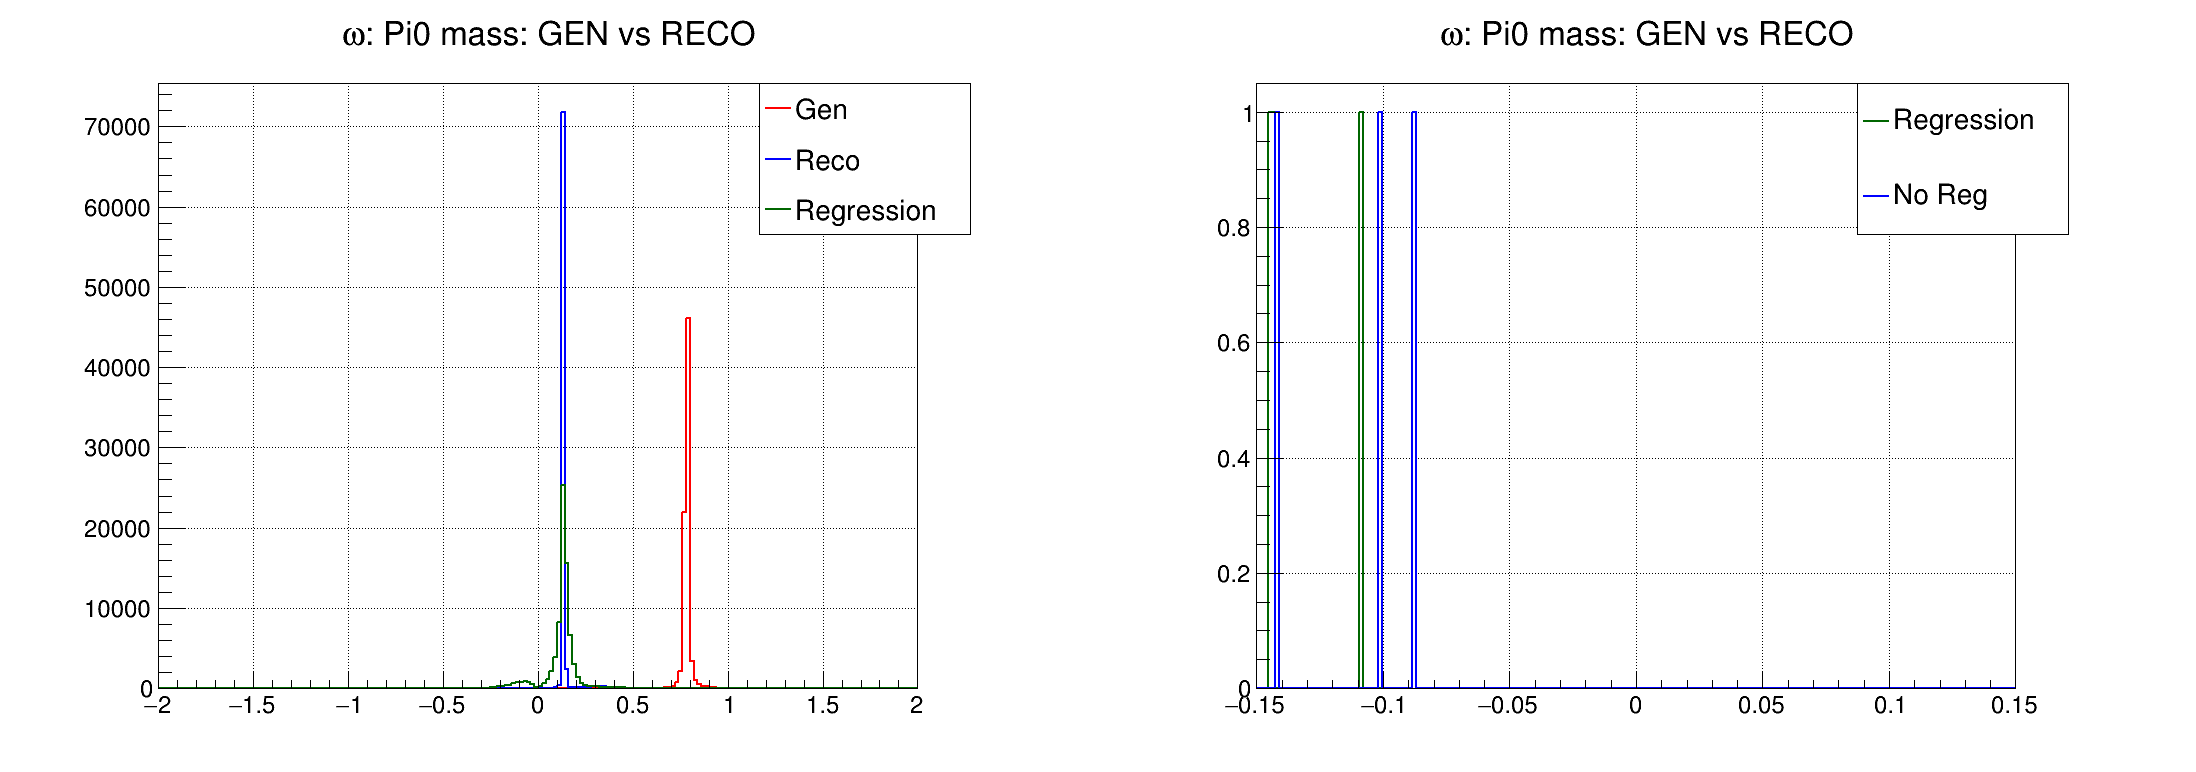

In [6]:
canvas = ROOT.TCanvas("canvas", "canvas", 2200, 800)
canvas.Divide(2, 1)

nbins, xlow, xhigh = 200, -2, 2

p = canvas.cd(1)

h1GEN1 = dfSGN0.Histo1D(("1Dhist", "#{channel}: pi0 mass Gen".format(channel=channel), nbins, xlow, xhigh), "Diff_meson_ditrack_mass_GEN").GetValue()
h1GEN1.Add(dfSGN1.Histo1D(("1Dhist", "#{channel}: pi0 mass Gen".format(channel=channel), nbins, xlow, xhigh), "Diff_meson_ditrack_mass_GEN").GetValue())
h1GEN1.Add(dfSGN2.Histo1D(("1Dhist", "#{channel}: pi0 mass Gen".format(channel=channel), nbins, xlow, xhigh), "Diff_meson_ditrack_mass_GEN").GetValue())

h1GEN1.GetXaxis().SetTitle("pi0 mass")
h1GEN1.GetYaxis().SetTitle("Events")
h1GEN1.SetLineWidth(2)
h1GEN1.SetLineColor(ROOT.kRed)

h1Regr = dfSGN0.Histo1D(("1Dhist", "#{channel}: pi0 mass Reco".format(channel=channel), nbins, xlow, xhigh), "Diff_meson_ditrack_mass").GetValue()
h1Regr.Add(dfSGN1.Histo1D(("1Dhist", "#{channel}: pi0 mass Reco".format(channel=channel), nbins, xlow, xhigh), "Diff_meson_ditrack_mass").GetValue())
h1Regr.Add(dfSGN2.Histo1D(("1Dhist", "#{channel}: pi0 mass Reco".format(channel=channel), nbins, xlow, xhigh), "Diff_meson_ditrack_mass").GetValue())

h1Regr.GetXaxis().SetTitle("pi0 mass")
h1Regr.GetYaxis().SetTitle("Events")
h1Regr.SetLineWidth(2)
h1Regr.SetLineColor(ROOT.kGreen+3)

h1Reco = dfSGN0.Histo1D(("1Dhist", "#{channel}: pi0 mass Reco".format(channel=channel), nbins, xlow, xhigh), "Diff_meson_ditrack_mass_noReg").GetValue()
h1Reco.Add(dfSGN1.Histo1D(("1Dhist", "#{channel}: pi0 mass Reco".format(channel=channel), nbins, xlow, xhigh), "Diff_meson_ditrack_mass_noReg").GetValue())
h1Reco.Add(dfSGN2.Histo1D(("1Dhist", "#{channel}: pi0 mass Reco".format(channel=channel), nbins, xlow, xhigh), "Diff_meson_ditrack_mass_noReg").GetValue())

h1Reco.GetXaxis().SetTitle("pi0 mass")
h1Reco.GetYaxis().SetTitle("Events")
h1Reco.SetLineWidth(2)
h1Reco.SetLineColor(ROOT.kBlue)

p.SetRightMargin(0.15)
p.SetLeftMargin(0.13)
p.SetGrid()

stack4 = ROOT.THStack("stack", "#{channel}: Pi0 mass: GEN vs RECO".format(channel=channel))
stack4.Add(h1GEN1)
stack4.Add(h1Reco)
stack4.Add(h1Regr)
stack4.Draw("hist nostack")
legend4 = ROOT.TLegend(0.70, 0.70, 0.9, 0.9)
legend4.SetMargin(0.17)
legend4.SetTextSize(0.04)
legend4.AddEntry(h1GEN1, "Gen", "l")
legend4.AddEntry(h1Reco, "Reco", "l")
legend4.AddEntry(h1Regr, "Regression", "l")
legend4.Draw()


p = canvas.cd(2)

xlen = 0.15
nbins, xlow, xhigh = 200, -xlen, xlen
h1DiffReg = dfSGN0.Define("diff", "Diff_meson_ditrack_mass - Diff_meson_ditrack_mass_GEN").Histo1D(("1Dhist", "#{channel}: Diff mass".format(channel=channel), nbins, xlow, xhigh), "diff").GetValue()
h1DiffReg.Add(dfSGN1.Define("diff", "Diff_meson_ditrack_mass - Diff_meson_ditrack_mass_GEN").Histo1D(("1Dhist", "#{channel}: Diff mass".format(channel=channel), nbins, xlow, xhigh), "diff").GetValue())
h1DiffReg.Add(dfSGN2.Define("diff", "Diff_meson_ditrack_mass - Diff_meson_ditrack_mass_GEN").Histo1D(("1Dhist", "#{channel}: Diff mass".format(channel=channel), nbins, xlow, xhigh), "diff").GetValue())

h1DiffReg.GetXaxis().SetTitle("Diff")
h1DiffReg.GetYaxis().SetTitle("Events")
h1DiffReg.SetLineWidth(2)
h1DiffReg.SetLineColor(ROOT.kGreen+3)

h1DiffNoReg = dfSGN0.Define("diff", "Diff_meson_ditrack_mass_noReg - Diff_meson_ditrack_mass_GEN").Histo1D(("1Dhist", "#{channel}: Diff mass".format(channel=channel), nbins, xlow, xhigh), "diff").GetValue()
h1DiffNoReg.Add(dfSGN1.Define("diff", "Diff_meson_ditrack_mass_noReg - Diff_meson_ditrack_mass_GEN").Histo1D(("1Dhist", "#{channel}: Diff mass".format(channel=channel), nbins, xlow, xhigh), "diff").GetValue())
h1DiffNoReg.Add(dfSGN2.Define("diff", "Diff_meson_ditrack_mass_noReg - Diff_meson_ditrack_mass_GEN").Histo1D(("1Dhist", "#{channel}: Diff mass".format(channel=channel), nbins, xlow, xhigh), "diff").GetValue())

h1DiffNoReg.GetXaxis().SetTitle("Diff")
h1DiffNoReg.GetYaxis().SetTitle("Events")
h1DiffNoReg.SetLineWidth(2)
h1DiffNoReg.SetLineColor(ROOT.kBlue)

p.SetRightMargin(0.15)
p.SetLeftMargin(0.13)
p.SetGrid()

stack5 = ROOT.THStack("stack", "#{channel}: Pi0 mass: GEN vs RECO".format(channel=channel))
stack5.Add(h1DiffReg)
stack5.Add(h1DiffNoReg)
stack5.Draw("hist nostack")
legend5 = ROOT.TLegend(0.70, 0.70, 0.9, 0.9)
legend5.SetMargin(0.17)
legend5.SetTextSize(0.04)
legend5.AddEntry(h1DiffReg, "Regression", "l")
legend5.AddEntry(h1DiffNoReg, "No Reg", "l")
legend5.Draw()

canvas.Draw()

print("STD REGRESSION:\t", h1DiffReg.GetStdDev())
print("STD NO REGRESSION:\t", h1DiffNoReg.GetStdDev())

In [7]:
modelName="BDTG_df7_dl3684_v0_v1_opt12167"
channel="d0star"
date = "SEP25"

s = '''
    TMVA::Experimental::RReader modelScaleD0Star0("/data/submit/pdmonte/TMVA_models/weightsOpts2/TMVARegression_{modelName}_{channel}_0.weights.xml");
    computeModelScaleD0Star0 = TMVA::Experimental::Compute<{numVarsTotal}, float>(modelScaleD0Star0);
    '''.format(modelName=modelName, channel=channel, numVarsTotal=getTotalNumVars(modelName))
s += '''
    TMVA::Experimental::RReader modelScaleD0Star1("/data/submit/pdmonte/TMVA_models/weightsOpts2/TMVARegression_{modelName}_{channel}_1.weights.xml");
    computeModelScaleD0Star1 = TMVA::Experimental::Compute<{numVarsTotal}, float>(modelScaleD0Star1);
    '''.format(modelName=modelName, channel=channel, numVarsTotal=getTotalNumVars(modelName))
s += '''
    TMVA::Experimental::RReader modelScaleD0Star2("/data/submit/pdmonte/TMVA_models/weightsOpts2/TMVARegression_{modelName}_{channel}_2.weights.xml");
    computeModelScaleD0Star2 = TMVA::Experimental::Compute<{numVarsTotal}, float>(modelScaleD0Star2);
    '''.format(modelName=modelName, channel=channel, numVarsTotal=getTotalNumVars(modelName))

ROOT.gInterpreter.ProcessLine(s)
variables = list(ROOT.modelScaleD0Star0.GetVariableNames())

mesonCat = ""
mesonNum = 0
if (channel == "omega"):
    mesonCat = "OmegaCat"
    mesonNum = 1038
elif (channel == "phi"):
    mesonCat = "Phi3Cat"
    mesonNum = 1039
elif (channel == "d0starrho"):
    mesonCat = "D0StarRhoCat"
    mesonNum = 1040
elif (channel == "d0star"):
    mesonCat = "D0StarCat"
    mesonNum = 1041
else:
    raise Exception("Wrong channel.")

chainSGN0 = ROOT.TChain("events")
chainSGN1 = ROOT.TChain("events")
chainSGN2 = ROOT.TChain("events")
chainSGN0.Add("/data/submit/pdmonte/outputs/{0}/2018/outname_mc{1}_GFcat_{2}_2018_sample0.root".format(date, mesonNum, mesonCat))
chainSGN1.Add("/data/submit/pdmonte/outputs/{0}/2018/outname_mc{1}_GFcat_{2}_2018_sample1.root".format(date, mesonNum, mesonCat))
chainSGN2.Add("/data/submit/pdmonte/outputs/{0}/2018/outname_mc{1}_GFcat_{2}_2018_sample2.root".format(date, mesonNum, mesonCat))

dfSGN0 = ROOT.RDataFrame(chainSGN0)
dfSGN1 = ROOT.RDataFrame(chainSGN1)
dfSGN2 = ROOT.RDataFrame(chainSGN2)

dfSGN0 = (dfSGN0.Define("scale", "w*lumiIntegrated/3.")
        .Define("HCandMass_GEN", "compute_HiggsVars_var(goodMeson_pt_GEN, goodMeson_eta_GEN, goodMeson_phi_GEN, goodMeson_mass_GEN, goodPhotons_pt_GEN, goodPhotons_eta_GEN, goodPhotons_phi_GEN, 0)")
        .Define("HCandMass_varGEN", "compute_HiggsVars_var(goodMeson_pt_GEN, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodPhotons_pt[0], goodPhotons_eta[0], goodPhotons_phi[0], 0)")
        .Define("scaleFactor", ROOT.computeModelScaleD0Star0, variables)
        .Define("goodMeson_pt_PRED", "scaleFactor[0]*goodMeson_pt[0]")
        .Define("HCandMass_varPRED", "compute_HiggsVars_var(goodMeson_pt_PRED, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodPhotons_pt[0], goodPhotons_eta[0], goodPhotons_phi[0], 0)")
        .Define("Diff_meson_ditrack_pt", "diff2Body(goodMeson_pt_PRED, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodMeson_ditrk_pt[0], goodMeson_ditrk_eta[0], goodMeson_ditrk_phi[0], goodMeson_ditrk_mass[0]).Pt()")
        .Define("Diff_meson_ditrack_pt_noReg", "diff2Body(goodMeson_pt[0], goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodMeson_ditrk_pt[0], goodMeson_ditrk_eta[0], goodMeson_ditrk_phi[0], goodMeson_ditrk_mass[0]).Pt()")
        .Define("Diff_meson_ditrack_pt_GEN", "diff2Body(goodMeson_pt_GEN, goodMeson_eta_GEN, goodMeson_phi_GEN, goodMeson_mass_GEN, goodMeson_ditrk_pt_GEN, goodMeson_ditrk_eta_GEN, goodMeson_ditrk_phi_GEN, goodMeson_ditrk_mass_GEN).Pt()")
        .Define("Diff_meson_ditrack_eta", "diff2Body(goodMeson_pt_PRED, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodMeson_ditrk_pt[0], goodMeson_ditrk_eta[0], goodMeson_ditrk_phi[0], goodMeson_ditrk_mass[0]).Eta()")
        .Define("Diff_meson_ditrack_eta_noReg", "diff2Body(goodMeson_pt[0], goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodMeson_ditrk_pt[0], goodMeson_ditrk_eta[0], goodMeson_ditrk_phi[0], goodMeson_ditrk_mass[0]).Eta()")
        .Define("Diff_meson_ditrack_eta_GEN", "diff2Body(goodMeson_pt_GEN, goodMeson_eta_GEN, goodMeson_phi_GEN, goodMeson_mass_GEN, goodMeson_ditrk_pt_GEN, goodMeson_ditrk_eta_GEN, goodMeson_ditrk_phi_GEN, goodMeson_ditrk_mass_GEN).Eta()")
        .Define("Diff_meson_ditrack_phi", "diff2Body(goodMeson_pt_PRED, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodMeson_ditrk_pt[0], goodMeson_ditrk_eta[0], goodMeson_ditrk_phi[0], goodMeson_ditrk_mass[0]).Phi()")
        .Define("Diff_meson_ditrack_phi_noReg", "diff2Body(goodMeson_pt[0], goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodMeson_ditrk_pt[0], goodMeson_ditrk_eta[0], goodMeson_ditrk_phi[0], goodMeson_ditrk_mass[0]).Phi()")
        .Define("Diff_meson_ditrack_phi_GEN", "diff2Body(goodMeson_pt_GEN, goodMeson_eta_GEN, goodMeson_phi_GEN, goodMeson_mass_GEN, goodMeson_ditrk_pt_GEN, goodMeson_ditrk_eta_GEN, goodMeson_ditrk_phi_GEN, goodMeson_ditrk_mass_GEN).Phi()")
        .Define("Diff_meson_ditrack_mass", "diff2Body(goodMeson_pt_PRED, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodMeson_ditrk_pt[0], goodMeson_ditrk_eta[0], goodMeson_ditrk_phi[0], goodMeson_ditrk_mass[0]).M()")
        .Define("Diff_meson_ditrack_mass_noReg", "diff2Body(goodMeson_pt[0], goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodMeson_ditrk_pt[0], goodMeson_ditrk_eta[0], goodMeson_ditrk_phi[0], goodMeson_ditrk_mass[0]).M()")
        .Define("Diff_meson_ditrack_mass_GEN", "diff2Body(goodMeson_pt_GEN, goodMeson_eta_GEN, goodMeson_phi_GEN, goodMeson_mass_GEN, goodMeson_ditrk_pt_GEN, goodMeson_ditrk_eta_GEN, goodMeson_ditrk_phi_GEN, goodMeson_ditrk_mass_GEN).M()"))
dfSGN1 = (dfSGN1.Define("scale", "w*lumiIntegrated/3.")
        .Define("HCandMass_GEN", "compute_HiggsVars_var(goodMeson_pt_GEN, goodMeson_eta_GEN, goodMeson_phi_GEN, goodMeson_mass_GEN, goodPhotons_pt_GEN, goodPhotons_eta_GEN, goodPhotons_phi_GEN, 0)")
        .Define("HCandMass_varGEN", "compute_HiggsVars_var(goodMeson_pt_GEN, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodPhotons_pt[0], goodPhotons_eta[0], goodPhotons_phi[0], 0)")
        .Define("scaleFactor", ROOT.computeModelScaleD0Star1, variables)
        .Define("goodMeson_pt_PRED", "scaleFactor[0]*goodMeson_pt[0]")
        .Define("HCandMass_varPRED", "compute_HiggsVars_var(goodMeson_pt_PRED, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodPhotons_pt[0], goodPhotons_eta[0], goodPhotons_phi[0], 0)")
        .Define("Diff_meson_ditrack_pt", "diff2Body(goodMeson_pt_PRED, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodMeson_ditrk_pt[0], goodMeson_ditrk_eta[0], goodMeson_ditrk_phi[0], goodMeson_ditrk_mass[0]).Pt()")
        .Define("Diff_meson_ditrack_pt_noReg", "diff2Body(goodMeson_pt[0], goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodMeson_ditrk_pt[0], goodMeson_ditrk_eta[0], goodMeson_ditrk_phi[0], goodMeson_ditrk_mass[0]).Pt()")
        .Define("Diff_meson_ditrack_pt_GEN", "diff2Body(goodMeson_pt_GEN, goodMeson_eta_GEN, goodMeson_phi_GEN, goodMeson_mass_GEN, goodMeson_ditrk_pt_GEN, goodMeson_ditrk_eta_GEN, goodMeson_ditrk_phi_GEN, goodMeson_ditrk_mass_GEN).Pt()")
        .Define("Diff_meson_ditrack_eta", "diff2Body(goodMeson_pt_PRED, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodMeson_ditrk_pt[0], goodMeson_ditrk_eta[0], goodMeson_ditrk_phi[0], goodMeson_ditrk_mass[0]).Eta()")
        .Define("Diff_meson_ditrack_eta_noReg", "diff2Body(goodMeson_pt[0], goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodMeson_ditrk_pt[0], goodMeson_ditrk_eta[0], goodMeson_ditrk_phi[0], goodMeson_ditrk_mass[0]).Eta()")
        .Define("Diff_meson_ditrack_eta_GEN", "diff2Body(goodMeson_pt_GEN, goodMeson_eta_GEN, goodMeson_phi_GEN, goodMeson_mass_GEN, goodMeson_ditrk_pt_GEN, goodMeson_ditrk_eta_GEN, goodMeson_ditrk_phi_GEN, goodMeson_ditrk_mass_GEN).Eta()")
        .Define("Diff_meson_ditrack_phi", "diff2Body(goodMeson_pt_PRED, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodMeson_ditrk_pt[0], goodMeson_ditrk_eta[0], goodMeson_ditrk_phi[0], goodMeson_ditrk_mass[0]).Phi()")
        .Define("Diff_meson_ditrack_phi_noReg", "diff2Body(goodMeson_pt[0], goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodMeson_ditrk_pt[0], goodMeson_ditrk_eta[0], goodMeson_ditrk_phi[0], goodMeson_ditrk_mass[0]).Phi()")
        .Define("Diff_meson_ditrack_phi_GEN", "diff2Body(goodMeson_pt_GEN, goodMeson_eta_GEN, goodMeson_phi_GEN, goodMeson_mass_GEN, goodMeson_ditrk_pt_GEN, goodMeson_ditrk_eta_GEN, goodMeson_ditrk_phi_GEN, goodMeson_ditrk_mass_GEN).Phi()")
        .Define("Diff_meson_ditrack_mass", "diff2Body(goodMeson_pt_PRED, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodMeson_ditrk_pt[0], goodMeson_ditrk_eta[0], goodMeson_ditrk_phi[0], goodMeson_ditrk_mass[0]).M()")
        .Define("Diff_meson_ditrack_mass_noReg", "diff2Body(goodMeson_pt[0], goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodMeson_ditrk_pt[0], goodMeson_ditrk_eta[0], goodMeson_ditrk_phi[0], goodMeson_ditrk_mass[0]).M()")
        .Define("Diff_meson_ditrack_mass_GEN", "diff2Body(goodMeson_pt_GEN, goodMeson_eta_GEN, goodMeson_phi_GEN, goodMeson_mass_GEN, goodMeson_ditrk_pt_GEN, goodMeson_ditrk_eta_GEN, goodMeson_ditrk_phi_GEN, goodMeson_ditrk_mass_GEN).M()"))
dfSGN2 = (dfSGN2.Define("scale", "w*lumiIntegrated/3.")
        .Define("HCandMass_GEN", "compute_HiggsVars_var(goodMeson_pt_GEN, goodMeson_eta_GEN, goodMeson_phi_GEN, goodMeson_mass_GEN, goodPhotons_pt_GEN, goodPhotons_eta_GEN, goodPhotons_phi_GEN, 0)")
        .Define("HCandMass_varGEN", "compute_HiggsVars_var(goodMeson_pt_GEN, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodPhotons_pt[0], goodPhotons_eta[0], goodPhotons_phi[0], 0)")
        .Define("scaleFactor", ROOT.computeModelScaleD0Star2, variables)
        .Define("goodMeson_pt_PRED", "scaleFactor[0]*goodMeson_pt[0]")
        .Define("HCandMass_varPRED", "compute_HiggsVars_var(goodMeson_pt_PRED, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodPhotons_pt[0], goodPhotons_eta[0], goodPhotons_phi[0], 0)")
        .Define("Diff_meson_ditrack_pt", "diff2Body(goodMeson_pt_PRED, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodMeson_ditrk_pt[0], goodMeson_ditrk_eta[0], goodMeson_ditrk_phi[0], goodMeson_ditrk_mass[0]).Pt()")
        .Define("Diff_meson_ditrack_pt_noReg", "diff2Body(goodMeson_pt[0], goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodMeson_ditrk_pt[0], goodMeson_ditrk_eta[0], goodMeson_ditrk_phi[0], goodMeson_ditrk_mass[0]).Pt()")
        .Define("Diff_meson_ditrack_pt_GEN", "diff2Body(goodMeson_pt_GEN, goodMeson_eta_GEN, goodMeson_phi_GEN, goodMeson_mass_GEN, goodMeson_ditrk_pt_GEN, goodMeson_ditrk_eta_GEN, goodMeson_ditrk_phi_GEN, goodMeson_ditrk_mass_GEN).Pt()")
        .Define("Diff_meson_ditrack_eta", "diff2Body(goodMeson_pt_PRED, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodMeson_ditrk_pt[0], goodMeson_ditrk_eta[0], goodMeson_ditrk_phi[0], goodMeson_ditrk_mass[0]).Eta()")
        .Define("Diff_meson_ditrack_eta_noReg", "diff2Body(goodMeson_pt[0], goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodMeson_ditrk_pt[0], goodMeson_ditrk_eta[0], goodMeson_ditrk_phi[0], goodMeson_ditrk_mass[0]).Eta()")
        .Define("Diff_meson_ditrack_eta_GEN", "diff2Body(goodMeson_pt_GEN, goodMeson_eta_GEN, goodMeson_phi_GEN, goodMeson_mass_GEN, goodMeson_ditrk_pt_GEN, goodMeson_ditrk_eta_GEN, goodMeson_ditrk_phi_GEN, goodMeson_ditrk_mass_GEN).Eta()")
        .Define("Diff_meson_ditrack_phi", "diff2Body(goodMeson_pt_PRED, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodMeson_ditrk_pt[0], goodMeson_ditrk_eta[0], goodMeson_ditrk_phi[0], goodMeson_ditrk_mass[0]).Phi()")
        .Define("Diff_meson_ditrack_phi_noReg", "diff2Body(goodMeson_pt[0], goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodMeson_ditrk_pt[0], goodMeson_ditrk_eta[0], goodMeson_ditrk_phi[0], goodMeson_ditrk_mass[0]).Phi()")
        .Define("Diff_meson_ditrack_phi_GEN", "diff2Body(goodMeson_pt_GEN, goodMeson_eta_GEN, goodMeson_phi_GEN, goodMeson_mass_GEN, goodMeson_ditrk_pt_GEN, goodMeson_ditrk_eta_GEN, goodMeson_ditrk_phi_GEN, goodMeson_ditrk_mass_GEN).Phi()")
        .Define("Diff_meson_ditrack_mass", "diff2Body(goodMeson_pt_PRED, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodMeson_ditrk_pt[0], goodMeson_ditrk_eta[0], goodMeson_ditrk_phi[0], goodMeson_ditrk_mass[0]).M()")
        .Define("Diff_meson_ditrack_mass_noReg", "diff2Body(goodMeson_pt[0], goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodMeson_ditrk_pt[0], goodMeson_ditrk_eta[0], goodMeson_ditrk_phi[0], goodMeson_ditrk_mass[0]).M()")
        .Define("Diff_meson_ditrack_mass_GEN", "diff2Body(goodMeson_pt_GEN, goodMeson_eta_GEN, goodMeson_phi_GEN, goodMeson_mass_GEN, goodMeson_ditrk_pt_GEN, goodMeson_ditrk_eta_GEN, goodMeson_ditrk_phi_GEN, goodMeson_ditrk_mass_GEN).M()"))

STD REGRESSION:	 1.9208586206772398
STD NO REGRESSION:	 2.939968158372622


Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


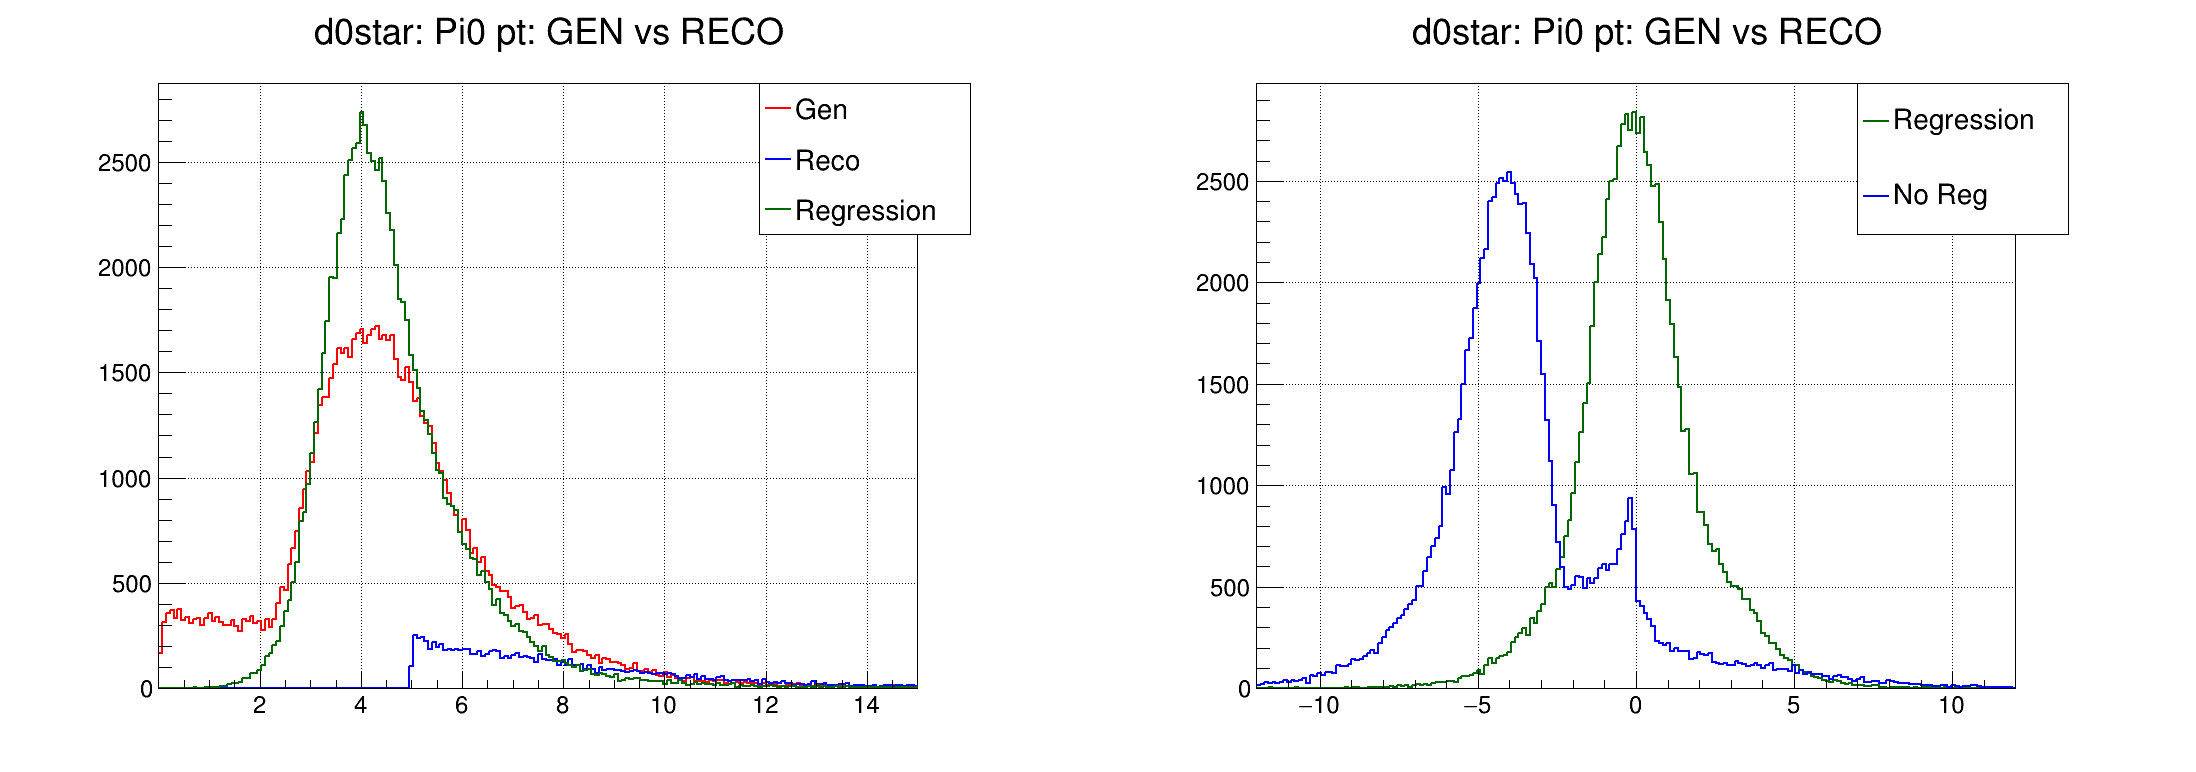

In [8]:
canvas = ROOT.TCanvas("canvas", "canvas", 2200, 800)
canvas.Divide(2, 1)

nbins, xlow, xhigh = 200, 0.001, 15

p = canvas.cd(1)

h1GEN1 = dfSGN0.Histo1D(("1Dhist", "{channel}: pi0 pt Gen".format(channel=channel), nbins, xlow, xhigh), "Diff_meson_ditrack_pt_GEN").GetValue()
h1GEN1.Add(dfSGN1.Histo1D(("1Dhist", "{channel}: pi0 pt Gen".format(channel=channel), nbins, xlow, xhigh), "Diff_meson_ditrack_pt_GEN").GetValue())
h1GEN1.Add(dfSGN2.Histo1D(("1Dhist", "{channel}: pi0 pt Gen".format(channel=channel), nbins, xlow, xhigh), "Diff_meson_ditrack_pt_GEN").GetValue())

h1GEN1.GetXaxis().SetTitle("pi0 pt")
h1GEN1.GetYaxis().SetTitle("Events")
h1GEN1.SetLineWidth(2)
h1GEN1.SetLineColor(ROOT.kRed)

h1Regr = dfSGN0.Histo1D(("1Dhist", "{channel}: pi0 pt Reco".format(channel=channel), nbins, xlow, xhigh), "Diff_meson_ditrack_pt").GetValue()
h1Regr.Add(dfSGN1.Histo1D(("1Dhist", "{channel}: pi0 pt Reco".format(channel=channel), nbins, xlow, xhigh), "Diff_meson_ditrack_pt").GetValue())
h1Regr.Add(dfSGN2.Histo1D(("1Dhist", "{channel}: pi0 pt Reco".format(channel=channel), nbins, xlow, xhigh), "Diff_meson_ditrack_pt").GetValue())

h1Regr.GetXaxis().SetTitle("pi0 pt")
h1Regr.GetYaxis().SetTitle("Events")
h1Regr.SetLineWidth(2)
h1Regr.SetLineColor(ROOT.kGreen+3)

h1Reco = dfSGN0.Histo1D(("1Dhist", "{channel}: pi0 pt Reco".format(channel=channel), nbins, xlow, xhigh), "Diff_meson_ditrack_pt_noReg").GetValue()
h1Reco.Add(dfSGN1.Histo1D(("1Dhist", "{channel}: pi0 pt Reco".format(channel=channel), nbins, xlow, xhigh), "Diff_meson_ditrack_pt_noReg").GetValue())
h1Reco.Add(dfSGN2.Histo1D(("1Dhist", "{channel}: pi0 pt Reco".format(channel=channel), nbins, xlow, xhigh), "Diff_meson_ditrack_pt_noReg").GetValue())

h1Reco.GetXaxis().SetTitle("pi0 pt")
h1Reco.GetYaxis().SetTitle("Events")
h1Reco.SetLineWidth(2)
h1Reco.SetLineColor(ROOT.kBlue)

p.SetRightMargin(0.15)
p.SetLeftMargin(0.13)
p.SetGrid()

stack4 = ROOT.THStack("stack", "{channel}: Pi0 pt: GEN vs RECO".format(channel=channel))
stack4.Add(h1GEN1)
stack4.Add(h1Reco)
stack4.Add(h1Regr)
stack4.Draw("hist nostack")
legend4 = ROOT.TLegend(0.70, 0.70, 0.9, 0.9)
legend4.SetMargin(0.17)
legend4.SetTextSize(0.04)
legend4.AddEntry(h1GEN1, "Gen", "l")
legend4.AddEntry(h1Reco, "Reco", "l")
legend4.AddEntry(h1Regr, "Regression", "l")
legend4.Draw()


p = canvas.cd(2)

xlen = 12.
nbins, xlow, xhigh = 200, -xlen, xlen
h1DiffReg = dfSGN0.Define("diff", "Diff_meson_ditrack_pt - Diff_meson_ditrack_pt_GEN").Histo1D(("1Dhist", "{channel}: Diff pt".format(channel=channel), nbins, xlow, xhigh), "diff").GetValue()
h1DiffReg.Add(dfSGN1.Define("diff", "Diff_meson_ditrack_pt - Diff_meson_ditrack_pt_GEN").Histo1D(("1Dhist", "{channel}: Diff pt".format(channel=channel), nbins, xlow, xhigh), "diff").GetValue())
h1DiffReg.Add(dfSGN2.Define("diff", "Diff_meson_ditrack_pt - Diff_meson_ditrack_pt_GEN").Histo1D(("1Dhist", "{channel}: Diff pt".format(channel=channel), nbins, xlow, xhigh), "diff").GetValue())

h1DiffReg.GetXaxis().SetTitle("Diff")
h1DiffReg.GetYaxis().SetTitle("Events")
h1DiffReg.SetLineWidth(2)
h1DiffReg.SetLineColor(ROOT.kGreen+3)

h1DiffNoReg = dfSGN0.Define("diff", "Diff_meson_ditrack_pt_noReg - Diff_meson_ditrack_pt_GEN").Histo1D(("1Dhist", "{channel}: Diff pt".format(channel=channel), nbins, xlow, xhigh), "diff").GetValue()
h1DiffNoReg.Add(dfSGN1.Define("diff", "Diff_meson_ditrack_pt_noReg - Diff_meson_ditrack_pt_GEN").Histo1D(("1Dhist", "{channel}: Diff pt".format(channel=channel), nbins, xlow, xhigh), "diff").GetValue())
h1DiffNoReg.Add(dfSGN2.Define("diff", "Diff_meson_ditrack_pt_noReg - Diff_meson_ditrack_pt_GEN").Histo1D(("1Dhist", "{channel}: Diff pt".format(channel=channel), nbins, xlow, xhigh), "diff").GetValue())

h1DiffNoReg.GetXaxis().SetTitle("Diff")
h1DiffNoReg.GetYaxis().SetTitle("Events")
h1DiffNoReg.SetLineWidth(2)
h1DiffNoReg.SetLineColor(ROOT.kBlue)

p.SetRightMargin(0.15)
p.SetLeftMargin(0.13)
p.SetGrid()

stack5 = ROOT.THStack("stack", "{channel}: Pi0 pt: GEN vs RECO".format(channel=channel))
stack5.Add(h1DiffReg)
stack5.Add(h1DiffNoReg)
stack5.Draw("hist nostack")
legend5 = ROOT.TLegend(0.70, 0.70, 0.9, 0.9)
legend5.SetMargin(0.17)
legend5.SetTextSize(0.04)
legend5.AddEntry(h1DiffReg, "Regression", "l")
legend5.AddEntry(h1DiffNoReg, "No Reg", "l")
legend5.Draw()

canvas.Draw()

print("STD REGRESSION:\t", h1DiffReg.GetStdDev())
print("STD NO REGRESSION:\t", h1DiffNoReg.GetStdDev())